In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from cetra import LightCurve, TransitModel, TransitDetector, concatenate_lightcurves

In [2]:
save_figures = False

## read the transit model

In [3]:
tm_dat = np.load("transit_model_HD101581.npz")
for k,v in tm_dat.items():
    print(k,v)
tmodel = TransitModel(tm_dat["model_array"])

model_array [0.99999985 0.99999989 0.99999969 ... 0.99999969 0.99999989 0.99999985]
rp 0.03
b 0.32
u [0.5 0.1]
period 10.0
semimajor_axis 20.0
user-provided transit model with 1048576 elements
transit model size: 1024 elements
maximum nearest-neighbour error: 1.09e+00%
   mean nearest-neighbour error: 9.78e-02%


## read the TESS data and detrend

In [4]:
tess_URLs = [
    "https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2023069172124-s0063-0000000397362481-0255-a_fast-lc.fits",
    "https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2023096110322-s0064-0000000397362481-0257-a_fast-lc.fits"
]

input light curve has 110964 elements, cadence: 20s (range: 20s -> 18561s)
constant flux model log-likelihood: 6.642e+05
resampled light curve has 114621 elements, cadence: 20s
obtaining trend
kernel 1 completed in 0.263 seconds
kernel 2 completed in 1.212 seconds
kernel 3 completed in 0.001 seconds
step 4 completed in 0.067 seconds
kernel 4 completed in 0.055 seconds
input light curve has 113433 elements, cadence: 20s (range: 20s -> 18500s)
constant flux model log-likelihood: 6.679e+05
resampled light curve has 116286 elements, cadence: 20s
obtaining trend
kernel 1 completed in 0.307 seconds
kernel 2 completed in 1.176 seconds
kernel 3 completed in 0.001 seconds
step 4 completed in 0.073 seconds
kernel 4 completed in 0.057 seconds


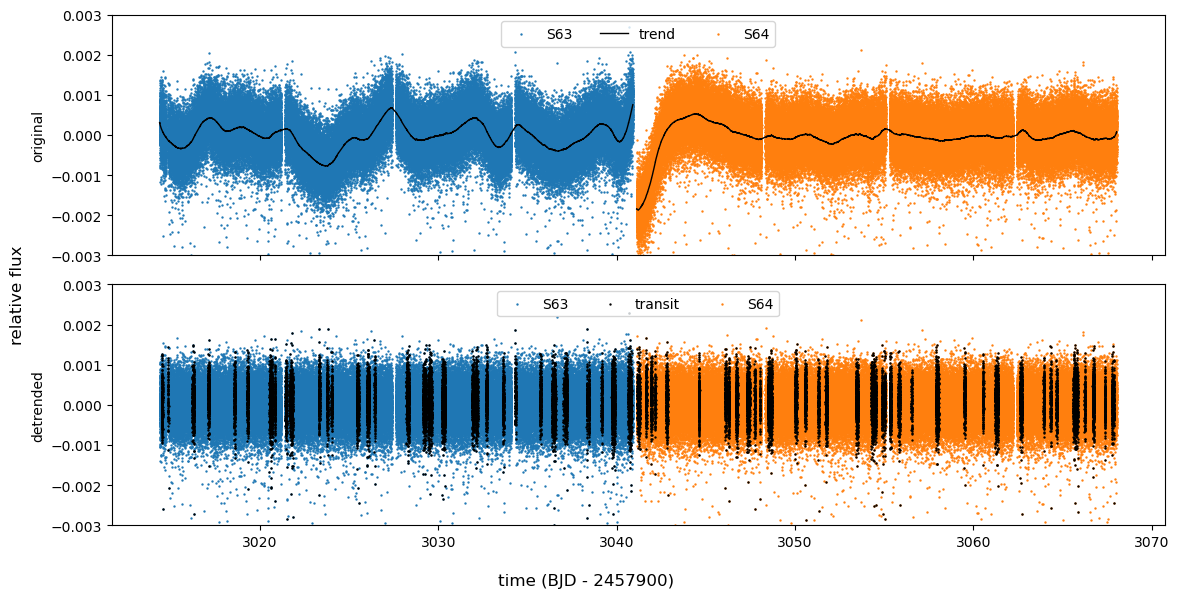

In [5]:
# plotting stuff
fig, axis = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
labels=["S63", "S64"]
colors = ["C0", "C1"]
tlab = ["trend", None]
trlab = ["transit", None]

# do the detrending and plotting
LCs = []
for i, url in enumerate(tess_URLs):
    # read data
    d = fits.getdata(url, 1, view=np.recarray)
    is_valid = np.isfinite(d['TIME']) & np.isfinite(d['PDCSAP_FLUX_ERR']) & np.isfinite(d['PDCSAP_FLUX'])
    time = d['TIME'][is_valid]
    flux = d['PDCSAP_FLUX'][is_valid]
    ferr = d['PDCSAP_FLUX_ERR'][is_valid]

    # normalise flux
    med_flux = np.median(flux)
    flux /= med_flux
    ferr /= med_flux

    # generate LightCurve instance
    _LC = LightCurve(times=time, fluxes=flux, flux_errors=ferr)

    # initialise transit detector
    td = TransitDetector(_LC, transit_model=tmodel, max_duration=0.2, verbose=False)

    # run detrending
    winsize_detection = 1.5
    winsize_detrending = 1.0
    n, ll_q, ll_t, dIC, tm, trend, em = td.get_trend(
        winsize_detection, winsize_detrending, 
        min_obs_count=50, full_output=True, IC_type=0, 
        dIC_threshold=10., min_depth_ppm=50.,
        verbose=True
    )

    # make plots
    axis[0].scatter(td.lc.time, td.lc.offset_flux, s=0.5, c=colors[i], label=labels[i])
    axis[0].plot(td.lc.time[np.isfinite(td.lc.offset_flux_error)], td.lc.offset_trend[np.isfinite(td.lc.offset_flux_error)], lw=1, c='k', label=tlab[i])
    axis[1].scatter(td.lc.time, td.lc.offset_flux - td.lc.offset_trend, s=0.5, c=colors[i], label=labels[i])
    axis[1].scatter(td.lc.time[tm>0], td.lc.offset_flux[tm>0] - td.lc.offset_trend[tm>0], c='k', s=0.5, label=trlab[i])
    
    LCs.append(td.lc.copy())

# finalise plots
axis[0].legend(ncol=3, loc='upper center')
axis[1].legend(ncol=3, loc='upper center')
axis[0].set_ylim(-0.003, 0.003)
axis[1].set_ylim(-0.003, 0.003)
fig.supylabel('relative flux')
axis[0].set_ylabel("original")
axis[1].set_ylabel("detrended")
fig.supxlabel('time (BJD - 2457900)')
plt.tight_layout()
if save_figures:
    plt.savefig("fig_HD101581_detrending.png", dpi=150, bbox_inches="tight")
plt.show()

## initialise the transit detector

In [6]:
# concatenate the light curves
LC = concatenate_lightcurves(LCs)

input light curve has 224397 elements, cadence: 20s (range: 20s -> 18561s)
constant flux model log-likelihood: 1.338e+06
resampled light curve has 231830 elements, cadence: 20s


In [7]:
# initialise transit detector
td = TransitDetector(LC, transit_model=tmodel, max_duration=0.5, verbose=True, t0_stride_fraction=0.01)

34 durations, 0.02 -> 0.46 days
padded 1004 null points to the start and 1004 null points to the end of the light curve
t0 stride length: 17.280 seconds
270645 t0 strides


## linear search test

In [8]:
linear_result = td.linear_search()

commencing linear search
trend available, subtracting
completed in 0.279 seconds


In [9]:
# for converting
#     duration_index <-> duration
darr = linear_result.duration_array
d_interp = interp1d(np.arange(darr.size), darr, kind='quadratic')
j_interp = interp1d(darr, np.arange(darr.size), kind='quadratic')

In [10]:
# y axis labels
yt = 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.2, 0.3, 0.45
yt_lab = [f"{y:.2f}" for y in yt]
#yt_lab.append("0.50")
yt_loc = j_interp(yt)

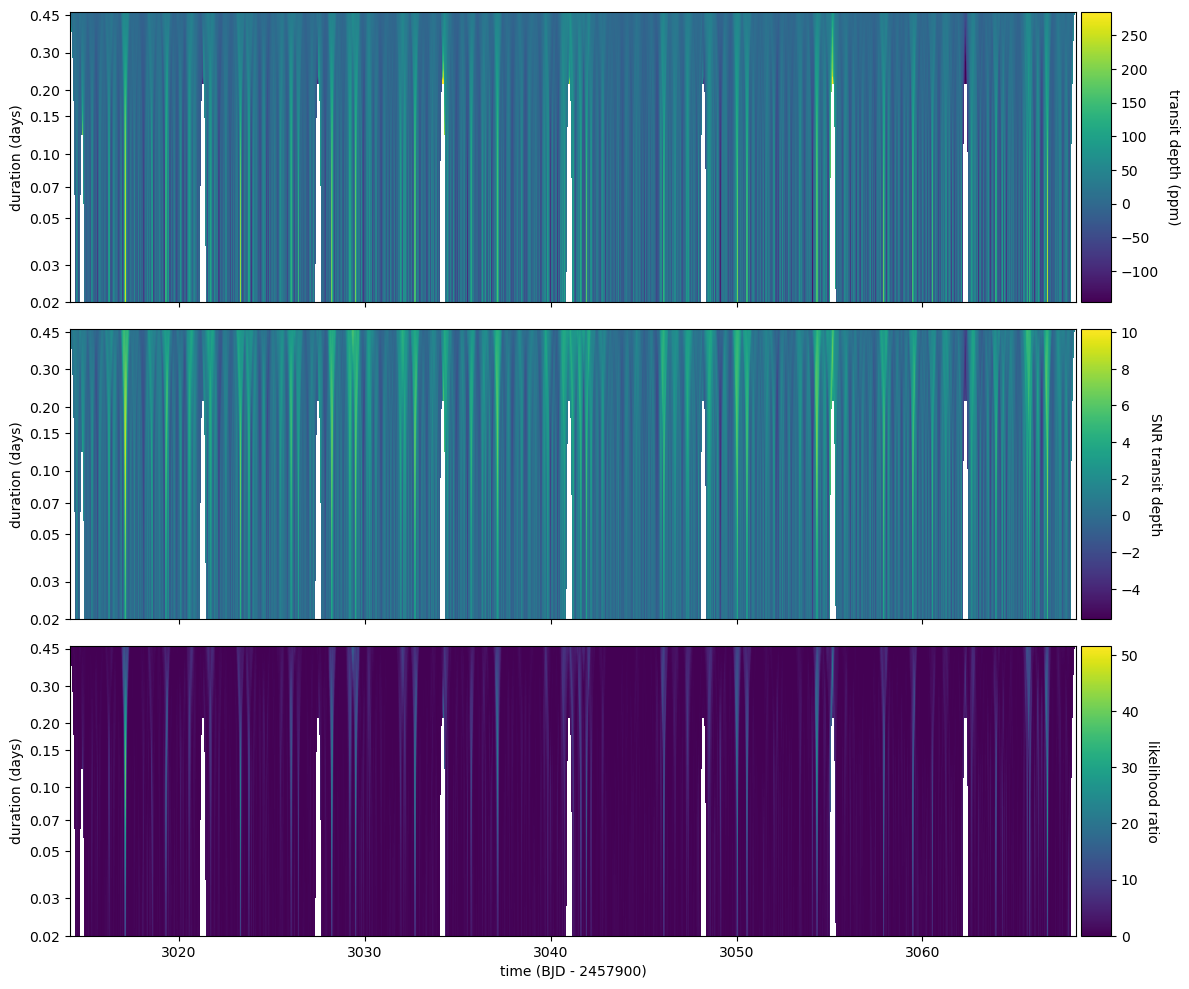

In [11]:
clip = 0.2
depth = linear_result.depth_array
depth_error = np.sqrt(linear_result.depth_variance_array)
lrat = linear_result.like_ratio_array
times = linear_result.light_curve.time
kwargs = {
    'aspect': 'auto',
    'cmap': 'viridis',
    'origin': 'lower',
    'extent': [times.min(), times.max(), 0, linear_result.duration_array.size-1]
}

fig, ax2 = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(12, 10))

# depth panel
divider = make_axes_locatable(ax2[0])
cax0 = divider.append_axes('right', size='3%', pad=0.05)
vmin, vmax = np.nanpercentile(depth*1e6, [clip, 100-clip])
im0 = ax2[0].imshow(depth * 1e6, vmin=vmin, vmax=vmax, **kwargs)
fig.colorbar(im0, cax=cax0, orientation='vertical')
cax0.get_yaxis().labelpad = 15
cax0.set_ylabel('transit depth (ppm)', rotation=270)
plt.sca(cax0)

# SNR panel
divider = make_axes_locatable(ax2[1])
cax1 = divider.append_axes('right', size='3%', pad=0.05)
im1 = ax2[1].imshow(depth/depth_error, **kwargs)
fig.colorbar(im1, cax=cax1, orientation='vertical')
cax1.get_yaxis().labelpad = 15
cax1.set_ylabel('SNR transit depth', rotation=270)

# LR panel
divider = make_axes_locatable(ax2[2])
cax2 = divider.append_axes('right', size='3%', pad=0.05)
im2 = ax2[2].imshow(lrat, **kwargs)
fig.colorbar(im2, cax=cax2, orientation='vertical')
cax2.get_yaxis().labelpad = 15
cax2.set_ylabel('likelihood ratio', rotation=270)

# axis labels
ax2[2].set_xlabel(r"time (BJD - 2457900)")
for ax in ax2:
    ax.set_ylabel("duration (days)")
    plt.sca(ax)
    plt.yticks(yt_loc, yt_lab)

plt.tight_layout()

if save_figures:
    plt.savefig("fig_HD101581_linear.png", bbox_inches='tight', dpi=150)

## period search test

In [12]:
period_result = td.period_search()

commencing periodic signal search
testing 5432 periods from 6.02e-01 to 2.68e+01 days


  0%|          | 0/5432 [00:00<?, ?it/s]

completed in 2.314 seconds


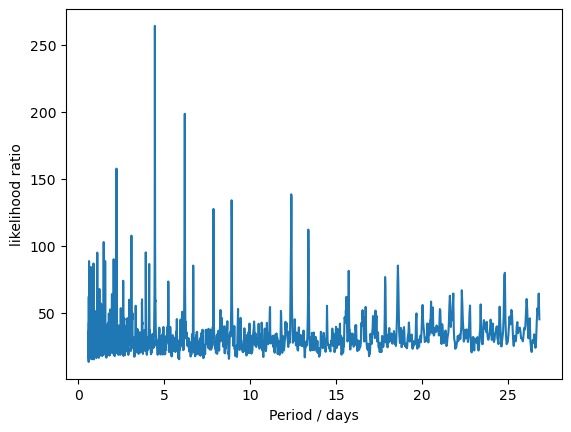

In [13]:
plt.plot(period_result.period_array, period_result.like_ratio_array)
plt.xlabel("Period / days")
plt.ylabel("likelihood ratio")
plt.show()

In [14]:
tr = period_result.get_max_likelihood_parameters()
print("ML", tr)
print("SNR:", tr.depth/tr.depth_error)

ML Transit(t0=3014.856241602053, duration=0.07594996671664828, depth=0.00018841206, depth_error=8.199329e-06, period=4.465103568398068)
SNR: 22.97896


## period detection loop

In [15]:
def transit_detection(i=0):
    print("")
    for _ in range(5):
        print("#"*120)
    print("")

    # run the linear search
    linear_result = td.linear_search()

    # just show the LR array for diagnostic purposes
    plt.figure(figsize=(12,6))
    plt.imshow(linear_result.like_ratio_array, aspect='auto', cmap='viridis', origin='lower', 
               extent=[linear_result.t0_array[0], linear_result.t0_array[-1], 0, linear_result.duration_array.size-1])
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('likelihood ratio', rotation=270)
    plt.xlabel(r"time (BJD - 2457900)")
    plt.ylabel("duration (days)")
    plt.yticks(yt_loc, yt_lab)
    plt.tight_layout()
    plt.show()

    # run the period search
    period_result = td.period_search()

    # plot the periodogram
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
    plt.sca(ax[0])
    plt.plot(period_result.period_array, period_result.like_ratio_array)
    plt.ylabel("likelihood ratio")
    plt.sca(ax[1])
    plt.plot(period_result.period_array, np.abs(period_result.depth_array) / np.sqrt(period_result.depth_variance_array))
    plt.xlabel("Period / days")
    plt.ylabel("SNR")
    plt.tight_layout()
    if save_figures:
        plt.savefig(f"fig_HD101581_periodogram_{i:d}.pdf", bbox_inches="tight")
    plt.show()

    # extract the highest likelihood periodic signal
    tr = period_result.get_max_likelihood_parameters()
    print(tr)
    print(f"SNR: {tr.depth/tr.depth_error:.2f}")
    
    return tr, period_result

### run it


########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################

commencing linear search
trend available, subtracting
completed in 0.321 seconds


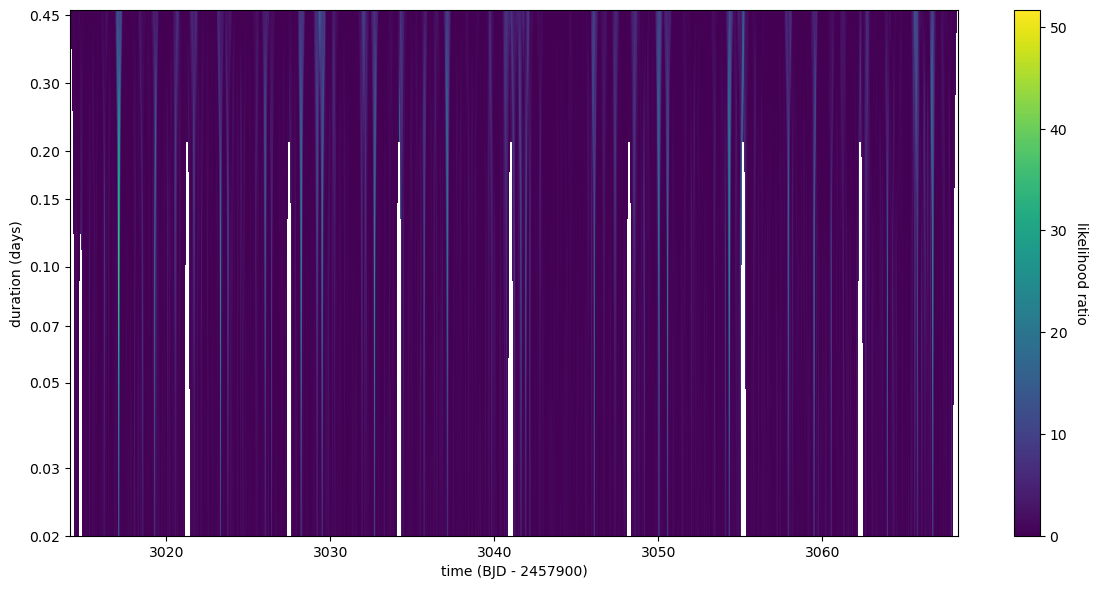

commencing periodic signal search
testing 5432 periods from 6.02e-01 to 2.68e+01 days


  0%|          | 0/5432 [00:00<?, ?it/s]

completed in 2.332 seconds


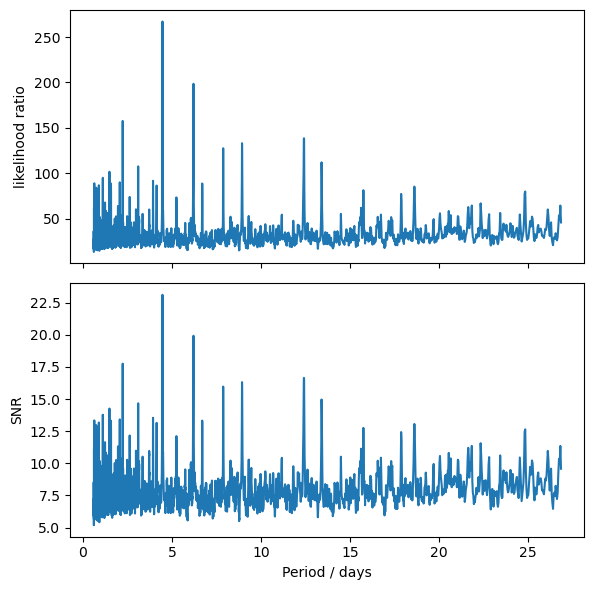

Transit(t0=3014.8518416020543, duration=0.06904542428786206, depth=0.00019935601, depth_error=8.626047e-06, period=4.465103568398068)
SNR: 23.11

########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################

commencing linear search
trend available, subtracting
completed in 0.293 seconds


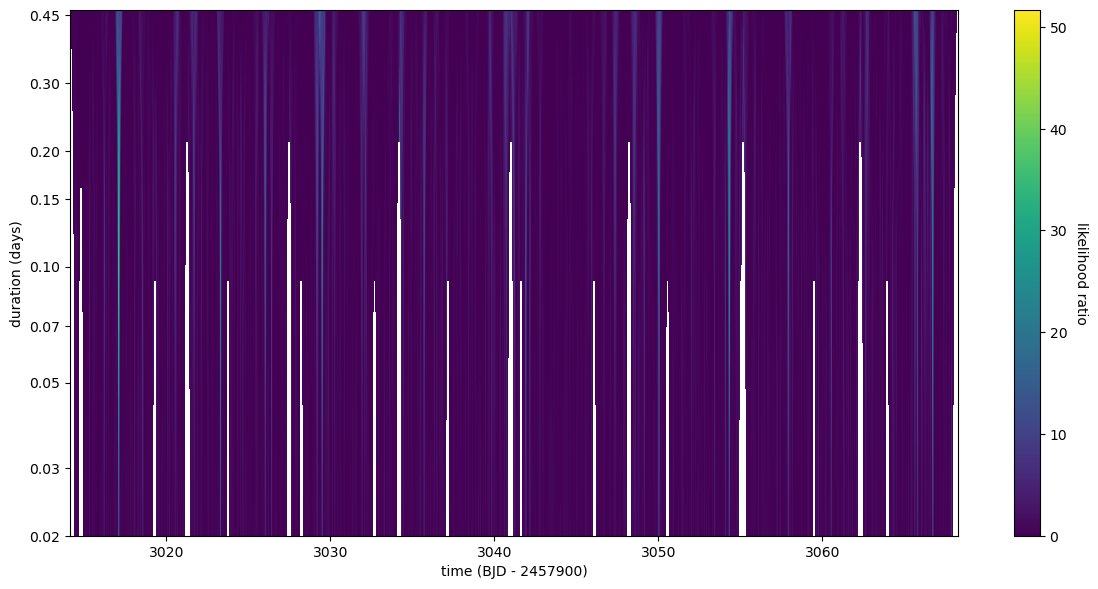

commencing periodic signal search
testing 5432 periods from 6.02e-01 to 2.68e+01 days


  0%|          | 0/5432 [00:00<?, ?it/s]

completed in 2.315 seconds


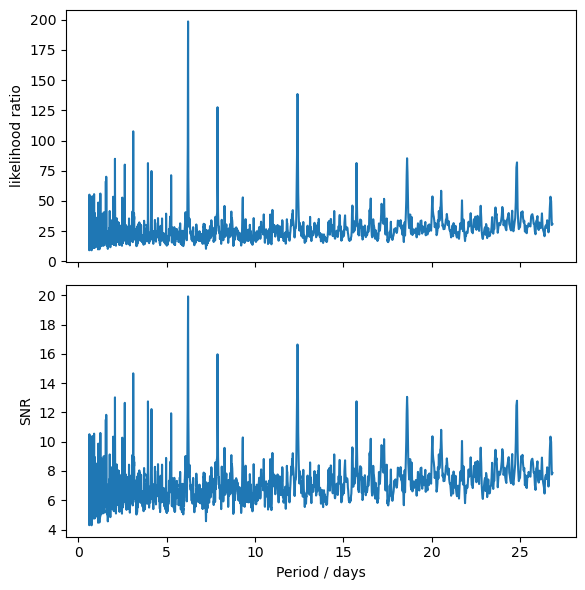

Transit(t0=3017.1100416014874, duration=0.06276856753442005, depth=0.00021401544, depth_error=1.0741181e-05, period=6.205637185446982)
SNR: 19.92

########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################

commencing linear search
trend available, subtracting
completed in 0.262 seconds


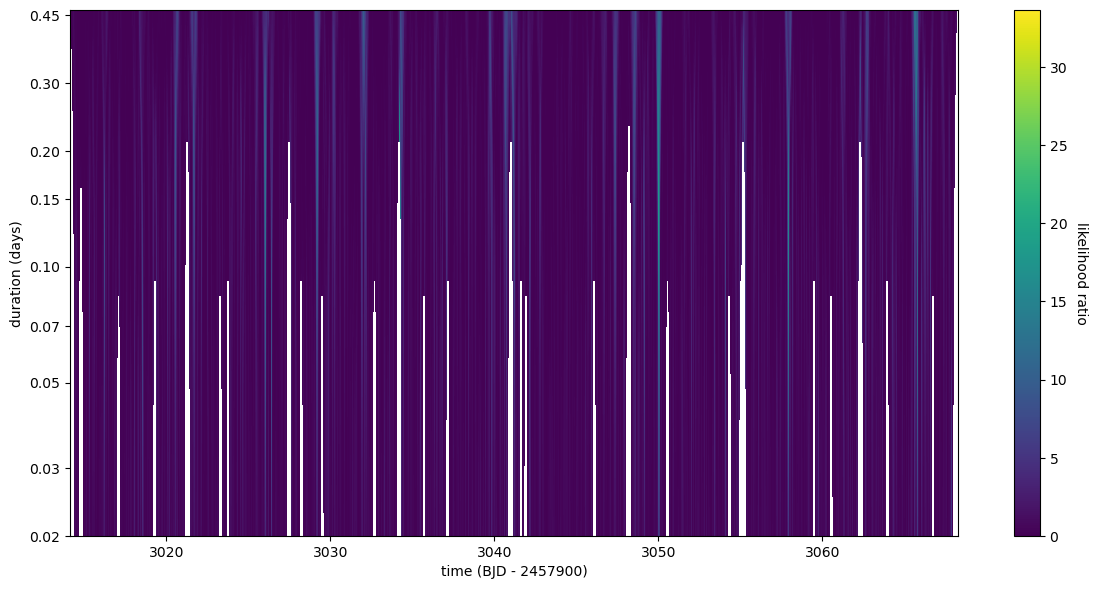

commencing periodic signal search
testing 5432 periods from 6.02e-01 to 2.68e+01 days


  0%|          | 0/5432 [00:00<?, ?it/s]

completed in 2.233 seconds


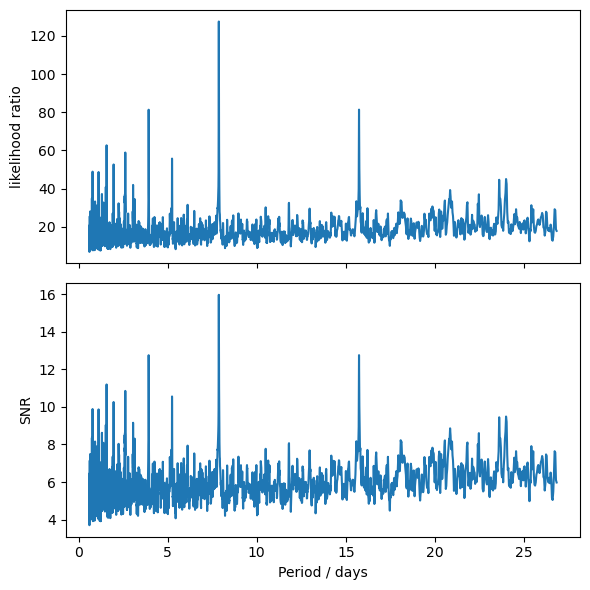

Transit(t0=3018.5672416011216, duration=0.06276856753442005, depth=0.00019060133, depth_error=1.1934868e-05, period=7.872858009218063)
SNR: 15.97


In [16]:
# re-init the transit detector, not strictly necessary
td = TransitDetector(LC, transit_model=tmodel, max_duration=0.5, verbose=False)
# somewhere to store the transits and periodic results
TCEs = []
PRs = []

# run the loop 3 times
for i in range(3):
    tr, pr = transit_detection(i=i)
    TCEs.append(tr)
    PRs.append(pr)
    # mask the max likelihood transit for the next run
    td.lc.mask_transit(tr, duration_multiplier=1.3)

### report the detected transits

In [17]:
print("TCE       t0         period   duration   depth   SNR")
print("      BJD-2457900     days      days      ppm       ")
for n, TCE in enumerate(TCEs):
    print(f" {n+1}     {TCE.t0:8.3f}       {TCE.period:5.3f}     {TCE.duration:5.3f}     "
          f"{TCE.depth*1e6:3.0f}    {TCE.depth/TCE.depth_error:.1f}")

TCE       t0         period   duration   depth   SNR
      BJD-2457900     days      days      ppm       
 1     3014.852       4.465     0.069     199    23.1
 2     3017.110       6.206     0.063     214    19.9
 3     3018.567       7.873     0.063     191    16.0


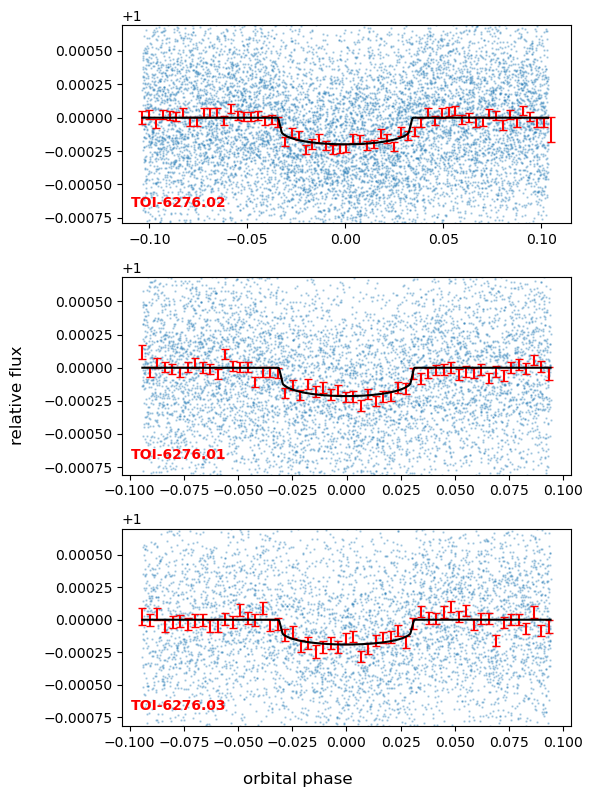

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))
names = ["TOI-6276.02", "TOI-6276.01", "TOI-6276.03"]
for n, TCE in enumerate(TCEs):
    phase, model = tmodel.get_model_lc(LC.time, TCE)
    
    plotsel = (np.abs(phase) < 1.5 * TCE.duration) & (LC.flux_weight>0)
    
    # bin the data
    _LC = LightCurve(times=phase[plotsel], 
                     fluxes=1-(LC.offset_flux - LC.offset_trend)[plotsel],
                     flux_errors=LC.offset_flux_error[plotsel],
                     resample_cadence=300., verbose=False
                    )
    
    plt.sca(axes[n])
    plt.scatter(phase[plotsel], 1 - (LC.offset_flux - LC.offset_trend)[plotsel], s=0.5, alpha=0.3)
    plt.errorbar(_LC.time, 1 - _LC.offset_flux, yerr=_LC.offset_flux_error, fmt=',', c='r', capsize=3)

    xx = phase[plotsel]
    order = np.argsort(xx)
    yy = model[plotsel][order]
    xx = xx[order]

    plt.plot(xx, yy, zorder=100, c='k', lw=1.5)

    vmin, vmax = np.nanpercentile(1 - (LC.offset_flux - LC.offset_trend)[plotsel], [5,95])
    plt.ylim(vmin, vmax)

    axes[n].text(0.02, 0.1, names[n], c='red',
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = axes[n].transAxes,
                weight='bold')
    
fig.supylabel('relative flux')
fig.supxlabel('orbital phase')
plt.tight_layout()
if save_figures:
    plt.savefig("fig_HD101581_TCEs.png", dpi=150, bbox_inches='tight')
plt.show()

In [19]:
assert False  # comment out to run the TLS benchmarking ahead

AssertionError: 

## TLS benchmarking

In [ ]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(LC.time, 1.0 - (LC.offset_flux - LC.offset_trend))

In [ ]:
results = model.power(use_threads=6)

In [ ]:
results = model.power(use_threads=1)